In [0]:
cd drive/

/content/drive


In [0]:
cd My\ Drive

/content/drive/My Drive


In [0]:
cd Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

Using TensorFlow backend.


In [0]:
face_images = glob.glob('lfw/lfw/**/*.jpg') #gives path

print(face_images[:2], len(face_images))

['lfw/lfw/Bashar_Assad/Bashar_Assad_0001.jpg', 'lfw/lfw/Bashar_Assad/Bashar_Assad_0002.jpg'] 13243


In [0]:
with open('face_images_path.pickle','wb') as f:
  pickle.dump(face_images,f)

In [0]:
from tqdm import tqdm         #A progess library

In [0]:
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, face_images)

 10%|█         | 1328/13243 [16:16<2:52:10,  1.15it/s]

In [0]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)

In [0]:
len(img_array)

13243

In [0]:
with open('img_array.pickle','rb') as f:
  img_array = pickle.load(f)

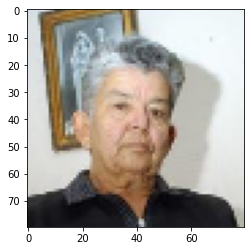

In [0]:
plt.imshow(img_array[100])

In [0]:
all_images = np.array(img_array)

In [0]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [0]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image


In [0]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

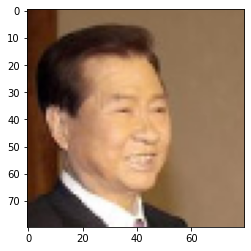

In [0]:

plt.imshow(train_x[100])

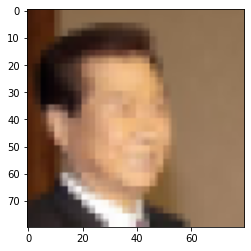

In [0]:
plt.imshow(train_x_px[100])

In [0]:
#lets build the model No TPU
#with strategy.scope():
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [0]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 80, 80, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 80, 80, 64)   36928       conv2d_98[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 40, 40, 64)   0           conv2d_99[0][0]                  
____________________________________________________________________________________________

In [0]:
# #Special dataset pipeline for running model on TPU
# def validation_input_fn(batch_size=1024):
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((val_x_px, val_x))
# # Shuffle, repeat, and batch the examples.
#     dataset = dataset.cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size, drop_remainder=True)
# # Return the dataset.
#     return dataset

In [0]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
332/332 [==============================] - 20s 60ms/step - loss: 0.0086 - accuracy: 0.8445 - val_loss: 0.0029 - val_accuracy: 0.8912
Epoch 2/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0027 - accuracy: 0.8979 - val_loss: 0.0026 - val_accuracy: 0.9052
Epoch 3/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0025 - accuracy: 0.9053 - val_loss: 0.0025 - val_accuracy: 0.9113
Epoch 4/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0024 - accuracy: 0.9097 - val_loss: 0.0024 - val_accuracy: 0.9174
Epoch 5/100
332/332 [==============================] - 21s 63ms/step - loss: 0.0024 - accuracy: 0.9108 - val_loss: 0.0024 - val_accuracy: 0.9104
Epoch 6/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0023 - accuracy: 0.9135 - val_loss: 0.0023 - val_accuracy: 0.9173
Epoch 7/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0023 - accuracy: 0.9146 - val_loss: 0.0023 - val_ac

In [0]:
autoencoder = tf.keras.models.load_model('superResolution_checkpoint3.h5')

In [0]:
predictions = autoencoder.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


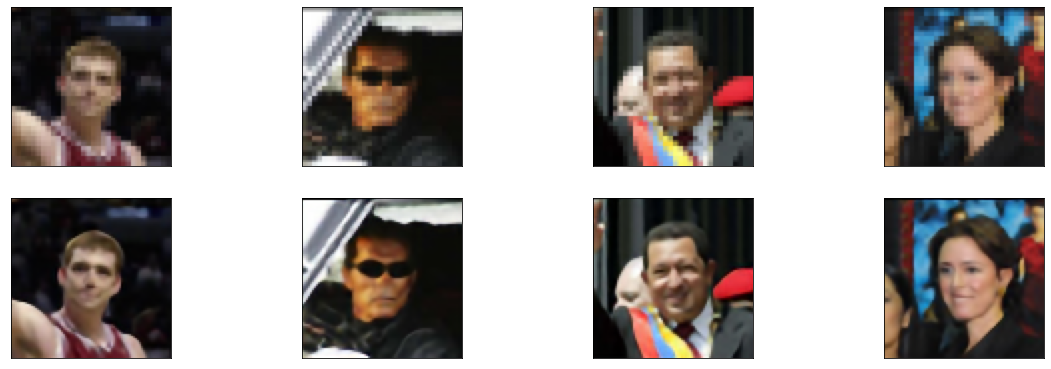

In [0]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

In [0]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

83/83 [==============================] - 2s 20ms/step - loss: 0.0021 - accuracy: 0.9279
loss, accuracy [0.002111854264512658, 0.9279356002807617]


In [0]:
img = image.load_img('download.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

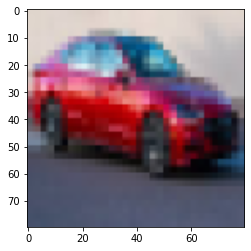

In [0]:
img = pixalate_image(img)
plt.imshow(img)

In [0]:

input_array = np.array([img])

In [0]:
predict = autoencoder.predict(input_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


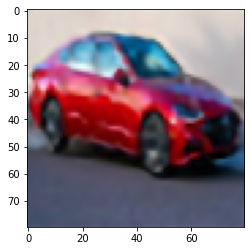

In [0]:
plt.imshow(predict[0])